In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix, roc_auc_score, auc, precision_recall_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import keras
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import time
import math
import warnings

warnings.filterwarnings("ignore")

2024-01-02 16:36:37.082171: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the dataset
train_file_path = 'train.gz'
df = pd.read_csv(train_file_path, compression='gzip', header=0, sep=',', quotechar='"')

# Display the first few rows of the dataframe
df.head()

id  click      hour    C1  banner_pos   site_id site_domain  \
0  1.000009e+18      0  14102100  1005           0  1fbe01fe    f3845767   
1  1.000017e+19      0  14102100  1005           0  1fbe01fe    f3845767   
2  1.000037e+19      0  14102100  1005           0  1fbe01fe    f3845767   
3  1.000064e+19      0  14102100  1005           0  1fbe01fe    f3845767   
4  1.000068e+19      0  14102100  1005           1  fe8cc448    9166c161   

  site_category    app_id app_domain  ... device_type device_conn_type    C14  \
0      28905ebd  ecad2386   7801e8d9  ...           1                2  15706   
1      28905ebd  ecad2386   7801e8d9  ...           1                0  15704   
2      28905ebd  ecad2386   7801e8d9  ...           1                0  15704   
3      28905ebd  ecad2386   7801e8d9  ...           1                0  15706   
4      0569f928  ecad2386   7801e8d9  ...           1                0  18993   

   C15  C16   C17  C18  C19     C20  C21  
0  320   50  1722    0   35      -1   79  
1  320   50  1722    0   35  100084   79  
2  320   50  1722    0   35  100084   79  
3  320   50  1722    0   35  100084   79  
4  320   50  2161    0   35      -1  157  

[5 rows x 24 columns]

In [3]:
# Checking data types and missing values
data_info = df.info()

# Summary statistics for numerical features
summary_statistics = df.describe()

summary_statistics, data_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40428967 entries, 0 to 40428966
Data columns (total 24 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                float64
 1   click             int64  
 2   hour              int64  
 3   C1                int64  
 4   banner_pos        int64  
 5   site_id           object 
 6   site_domain       object 
 7   site_category     object 
 8   app_id            object 
 9   app_domain        object 
 10  app_category      object 
 11  device_id         object 
 12  device_ip         object 
 13  device_model      object 
 14  device_type       int64  
 15  device_conn_type  int64  
 16  C14               int64  
 17  C15               int64  
 18  C16               int64  
 19  C17               int64  
 20  C18               int64  
 21  C19               int64  
 22  C20               int64  
 23  C21               int64  
dtypes: float64(1), int64(14), object(9)
memory usage: 7.2+ GB


(                 id         click          hour            C1    banner_pos  \
 count  4.042897e+07  4.042897e+07  4.042897e+07  4.042897e+07  4.042897e+07   
 mean   9.223017e+18  1.698056e-01  1.410256e+07  1.004968e+03  2.880146e-01   
 std    5.325443e+18  3.754620e-01  2.966837e+02  1.094586e+00  5.063820e-01   
 min    5.211594e+11  0.000000e+00  1.410210e+07  1.001000e+03  0.000000e+00   
 25%    4.611181e+18  0.000000e+00  1.410230e+07  1.005000e+03  0.000000e+00   
 50%    9.223224e+18  0.000000e+00  1.410260e+07  1.005000e+03  0.000000e+00   
 75%    1.383561e+19  0.000000e+00  1.410281e+07  1.005000e+03  1.000000e+00   
 max    1.844674e+19  1.000000e+00  1.410302e+07  1.012000e+03  7.000000e+00   
 
         device_type  device_conn_type           C14           C15  \
 count  4.042897e+07      4.042897e+07  4.042897e+07  4.042897e+07   
 mean   1.015305e+00      3.313150e-01  1.884181e+04  3.188831e+02   
 std    5.274336e-01      8.547935e-01  4.959457e+03  2.127250e+01  

In [3]:
# Converting 'click', 'C1', 'banner_pos', 'device_type', 'device_conn_type', and 'C14'-'C21' to numeric
numeric_cols = ['click', 'C1', 'banner_pos', 'device_type', 'device_conn_type'] + [f'C{i}' for i in range(14, 22)]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Now converting 'hour' to a datetime format
df['hour'] = pd.to_datetime(df['hour'], format='%y%m%d%H')

In [5]:
unique_values = df.nunique().sort_values(ascending=False)

unique_values

id                  40428967
device_ip            6729486
device_id            2686408
app_id                  8552
device_model            8251
site_domain             7745
site_id                 4737
C14                     2626
app_domain               559
C17                      435
hour                     240
C20                      172
C19                       68
C21                       60
app_category              36
site_category             26
C16                        9
C15                        8
C1                         7
banner_pos                 7
device_type                5
device_conn_type           4
C18                        4
click                      2
dtype: int64

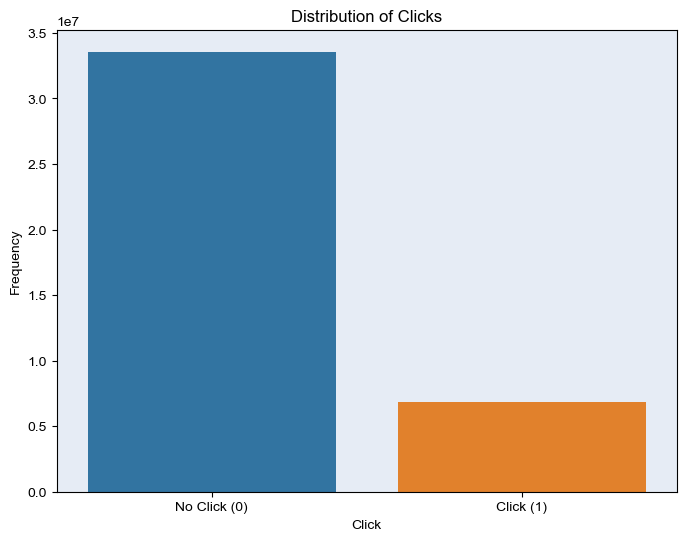

Click-Through Rate (CTR): 16.98%


In [6]:
# Analyzing the distribution of the target variable 'click'
click_distribution = df['click'].value_counts()

# Plotting the distribution

plt.figure(figsize=(8, 6))
sns.barplot(x=click_distribution.index, y=click_distribution.values)
sns.set_style("whitegrid", {'grid.linestyle': '-', 'axes.edgecolor': '1', 'grid.color': 'white'})
r, g, b = 230/255, 236/255, 245/255
plt.gca().set_facecolor((r, g, b))
plt.title('Distribution of Clicks')
plt.xlabel('Click')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['No Click (0)', 'Click (1)'])
plt.show()

CTR = (click_distribution[1] / len(df)) * 100
print("Click-Through Rate (CTR): {:0.2f}%".format(CTR))

In [4]:
week_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

df['hour of day'] = df['hour'].apply(lambda x: str(x.time())[:5])
df['day of week'] = df['hour'].apply(lambda x: week_days[x.weekday()])

# Calculating the sum of clicks and total number of ads for each 'hour'
click_hour = df.groupby('hour').agg({'click': 'sum', 'id': 'count'}).reset_index()
click_hour.columns = ['hour', 'total clicks', 'total ads']
click_hour['CTR'] = (click_hour['total clicks']/click_hour['total ads']) * 100

click_hr_day = df.groupby('hour of day').agg({'click': 'sum', 'id': 'count'}).reset_index()
click_hr_day.columns = ['hour of day', 'total clicks', 'total ads']
click_hr_day['CTR'] = (click_hr_day['total clicks']/click_hr_day['total ads']) * 100

click_day_wk = df.groupby('day of week').agg({'click': 'sum', 'id': 'count'}).reset_index()
click_day_wk.columns = ['day of week', 'total clicks', 'total ads']
click_day_wk['day of week'] = pd.Categorical(click_day_wk['day of week'], categories=week_days, ordered=True)
click_day_wk = click_day_wk.sort_values('day of week')
click_day_wk['CTR'] = (click_day_wk['total clicks']/click_day_wk['total ads']) * 100

ads = df.groupby(['hour of day', 'click']).size().unstack().reset_index()

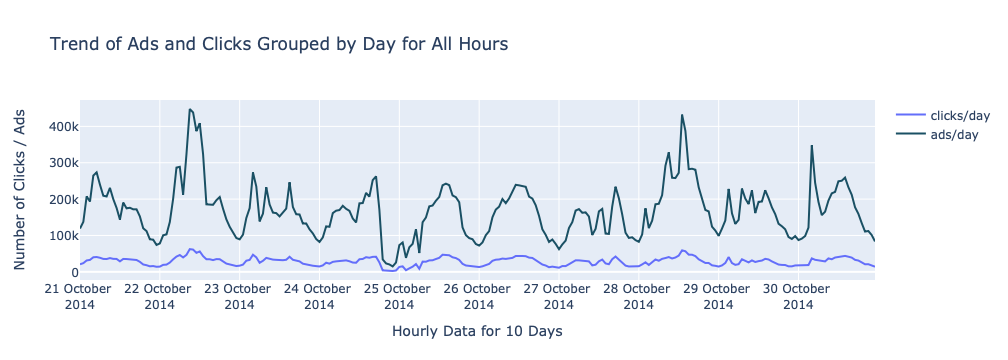

In [14]:
fig = go.Figure(data=[
    go.Scatter(
        name='clicks/day',
        x=click_hour['hour'],
        y=click_hour['total clicks'],
        hovertemplate='Date: %{x|%d %B %Y} <br>Time: %{x|%H:%M:%S} <br>Day: %{x|%A} <br>Clicks: %{y}'
    ),
    go.Scatter(
        name='ads/day',
        x=click_hour['hour'],
        y=click_hour['total ads'],
        hovertemplate='Date: %{x|%d %B %Y} <br>Time: %{x|%H:%M:%S} <br>Day: %{x|%A} <br>Ads: %{y}',
        marker_color='rgb(26, 80, 100)'
    )
])

fig.update_layout(
    title='Trend of Ads and Clicks Grouped by Day for All Hours',
    xaxis_tickformat='%d %B <br>%Y', 
    xaxis_title='Hourly Data for 10 Days',
    yaxis_title='Number of Clicks / Ads'
)

fig.show()


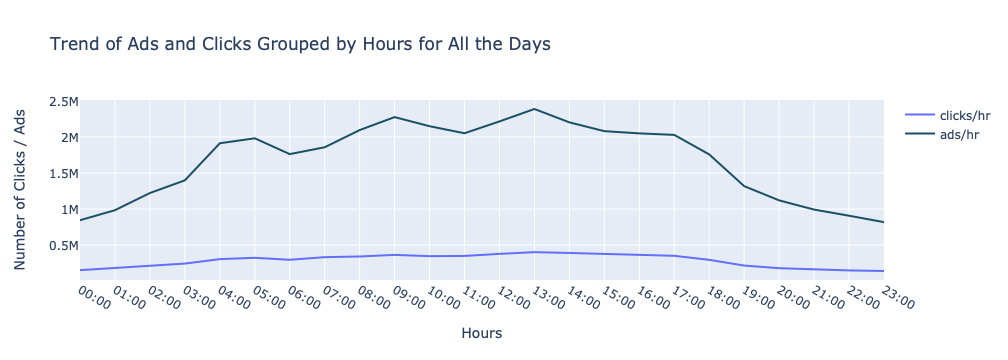

In [11]:
fig = go.Figure(data=[
    go.Scatter(
        name='clicks/hr',
        x=click_hr_day['hour of day'],
        y=click_hr_day['total clicks'],
        hovertemplate='Time: %{x} <br>Clicks: %{y}'
    ),
    go.Scatter(
        name='ads/hr',
        x=click_hr_day['hour of day'],
        y=click_hr_day['total ads'],
        hovertemplate='Time: %{x} <br>Ads: %{y}',
        marker_color='rgb(26, 80, 100)'
    )
])

fig.update_layout(
    title='Trend of Ads and Clicks Grouped by Hours for All the Days',
    xaxis_title='Hours',
    yaxis_title='Number of Clicks / Ads'
)

fig.show()


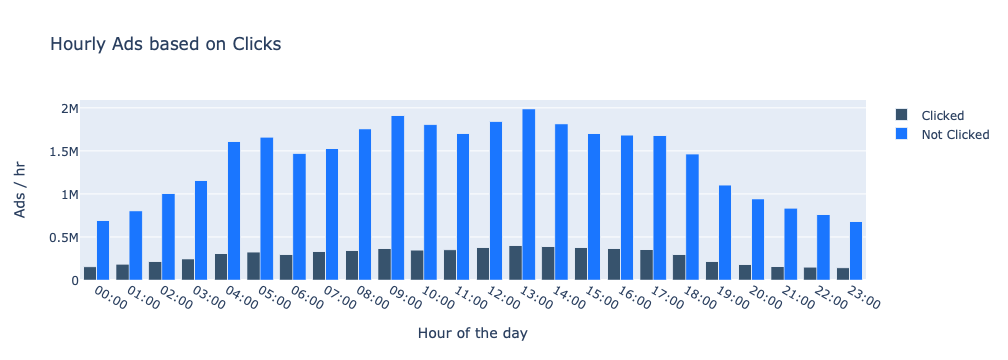

In [12]:
fig = go.Figure(data=[
    go.Bar(name='Clicked', x=ads["hour of day"], y=ads[1], 
           hovertemplate='Time: %{x} <br>Clicks: %{y}', marker_color='rgb(55, 83, 109)'),
    go.Bar(name='Not Clicked', x=ads["hour of day"], y=ads[0], 
           hovertemplate='Time: %{x} <br>Clicks: %{y}', marker_color='rgb(26, 118, 255)')
])
# Change the bar mode
fig.update_layout(
    title = 'Hourly Ads based on Clicks',
    xaxis_title = 'Hour of the day',
    yaxis_title = 'Ads / hr',
    barmode='group',
    xaxis_type = None
    )
fig.show()

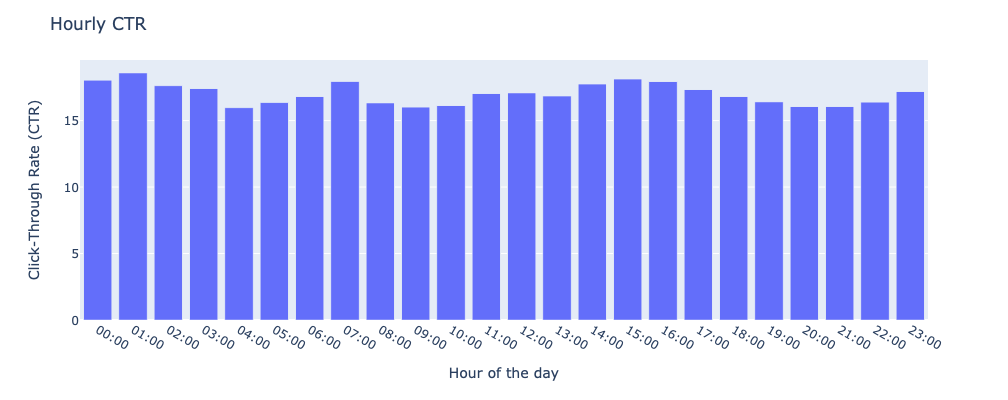

In [13]:
fig = px.bar(click_hr_day, x='hour of day', y='CTR',
             labels={'hour of day': 'Time'},
             height=400)

fig.update_layout(
    title = 'Hourly CTR',
    xaxis_title = 'Hour of the day',
    yaxis_title = 'Click-Through Rate (CTR)'',
    )
fig.show()

In [14]:
fig = px.bar(click_day_wk, x='day of week', y='CTR',
             labels={'day of week': 'Day'}, 
             height=400,)

fig.update_layout(
    title = 'Daily CTR',
    xaxis_title = 'Day of week',
    yaxis_title = 'Click-Through Rate (CTR)'',
    )
fig.show()

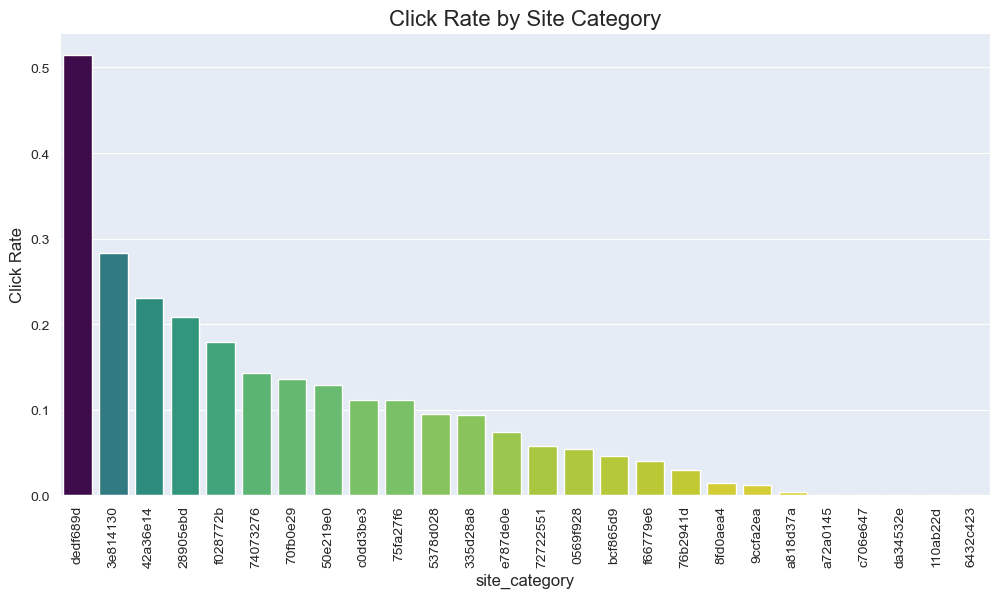

In [8]:
def plot_click_rate_by_category(feature, title, df, same_color=False):
    # Grouping by the feature and calculating click rate
    click_rate = df.groupby(feature)['click'].mean().sort_values(ascending=False)
    # Set the style with white gridlines
    sns.set_style('whitegrid', {'grid.linestyle': '-', 'axes.edgecolor': '1', 'grid.color': 'white'})

    plt.figure(figsize=(12, 6))
    
    if same_color:
        barplot = sns.barplot(x=click_rate.index, y=click_rate.values, color='cornflowerblue')
    else:
        # Create a reversed color palette that varies based on the bar height
        norm = plt.Normalize(click_rate.values.min(), click_rate.values.max())
        colors = plt.cm.viridis_r(norm(click_rate.values))  # Notice the "_r" suffix for reversed colormap
        barplot = sns.barplot(x=click_rate.index, y=click_rate.values, palette=colors)

    plt.title(title, fontsize=16)
    plt.ylabel('Click Rate', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize=10)

    # Convert RGB to Hex and set as background color
    r, g, b = 230/255, 236/255, 245/255
    plt.gca().set_facecolor((r, g, b))

    plt.show()


plot_click_rate_by_category('site_category', 'Click Rate by Site Category', df)

In [16]:
# Click Rate by App Category
plot_click_rate_by_category('app_category', 'Click Rate by App Category', df)

In [17]:
# Click Rate by Device Type
plot_click_rate_by_category('device_type', 'Click Rate by Device Type', df, same_color=True)

In [18]:
# Click Rate by Banner Position
plot_click_rate_by_category('banner_pos', 'Click Rate by Banner Position', df, same_color=True)

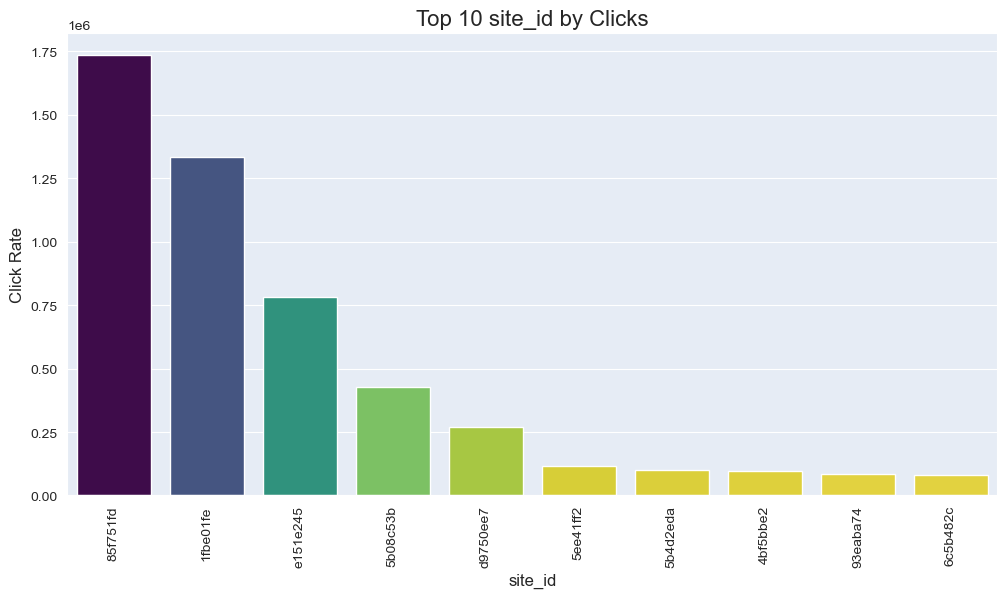

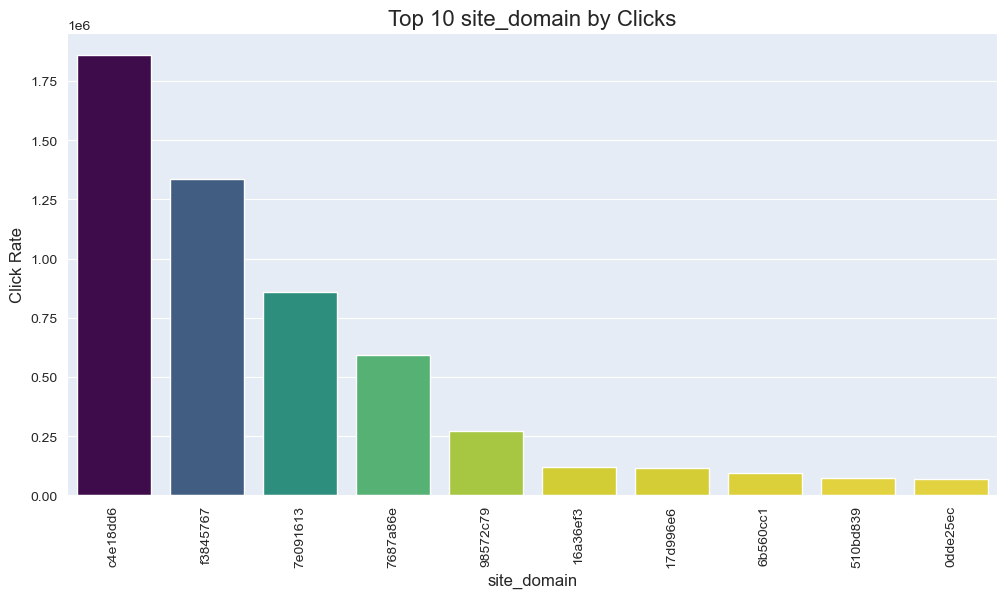

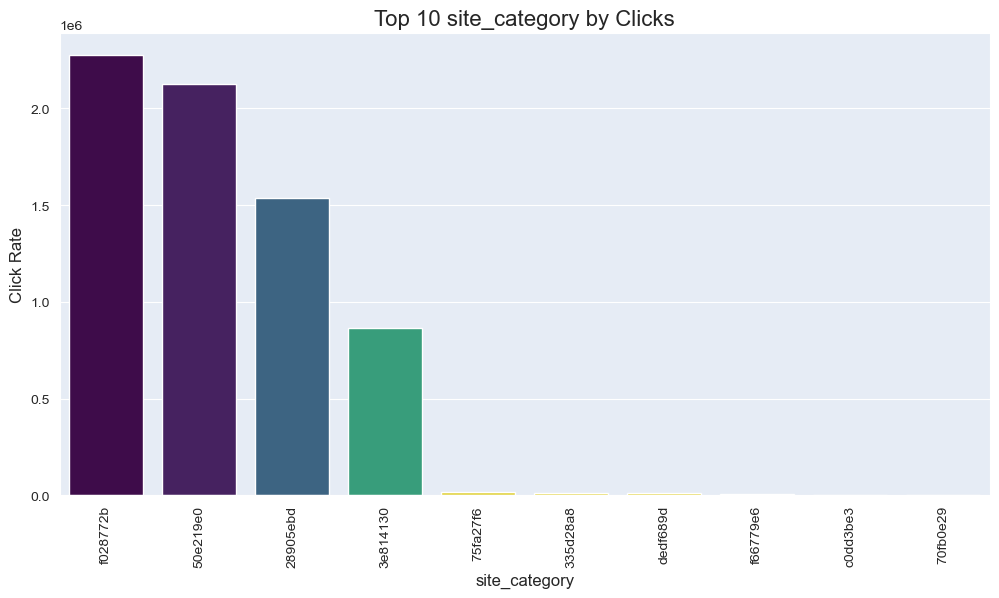

In [9]:
def plot_top_categories_by_clicks(feature,  df, top_n=10, same_color=False):
    # Grouping by the feature and calculating click rate
    feature_clicks = df.groupby(feature)['click'].sum().sort_values(ascending=False).head(top_n)
    # Set the style with white gridlines
    sns.set_style('whitegrid', {'grid.linestyle': '-', 'axes.edgecolor': '1', 'grid.color': 'white'})

    # Create a more visually appealing plot
    plt.figure(figsize=(12, 6))
    
    if same_color:
        barplot = sns.barplot(x=feature_clicks.index, y=feature_clicks.values, color='cornflowerblue')
    else:
        # Create a reversed color palette that varies based on the bar height
        norm = plt.Normalize(feature_clicks.values.min(), feature_clicks.values.max())
        colors = plt.cm.viridis_r(norm(feature_clicks.values))
        barplot = sns.barplot(x=feature_clicks.index, y=feature_clicks.values, palette=colors)

    plt.title(f'Top {top_n} {feature} by Clicks', fontsize=16)
    plt.ylabel('Click Rate', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize=10)

    # Convert RGB to Hex and set as background color
    r, g, b = 230/255, 236/255, 245/255
    plt.gca().set_facecolor((r, g, b))

    plt.show()


# Effect of Site Features on Clicks
#  Top 10 Site IDs by Clicks
plot_top_categories_by_clicks('site_id', df)

# Top 10 Site Domains by Clicks
plot_top_categories_by_clicks('site_domain', df)

# Top 10 Site Categories by Clicks
plot_top_categories_by_clicks('site_category', df)

In [20]:
# Effect of Device Features on Clicks
# Top 5 Device Types by Clicks
plot_top_categories_by_clicks('device_type', df, top_n=5, same_color=True)

# Top 10 Device Models by Clicks
plot_top_categories_by_clicks('device_model', df)

# Top 10 Device IDs by Clicks
plot_top_categories_by_clicks('device_id', df)

In [21]:
# Effect of App Features on Clicks
# Top 5 App IDs by Clicks
plot_top_categories_by_clicks('app_id', df)

# Top 5 App Domains by Clicks
plot_top_categories_by_clicks('app_domain', df)

# Top 5 App Categories by Clicks
plot_top_categories_by_clicks('app_category', df)

In [ ]:
# Checking for NaN values in the dataset
nan_values = df.isnull().sum()

# Identifying unique values for each column
unique_values_all = df.nunique().sort_values(ascending=False)

nan_values, unique_values_all

In [5]:
df['hour of day'] = df['hour of day'].apply(lambda x: int(x.split(':')[0]))
df = df.drop(['id', 'hour'], axis=1)

In [6]:
def convert_obj_to_int(fm):
    
    object_list_columns = fm.columns
    object_list_dtypes = fm.dtypes
    for index in range(0,len(object_list_columns)):
        if object_list_dtypes[index] == object :
            fm[object_list_columns[index]] = fm[object_list_columns[index]].apply(lambda x: hash(x))
    return fm

df_hashed = convert_obj_to_int(df)

df_hashed.head()

click    C1  banner_pos              site_id          site_domain  \
0      0  1005           0 -5764427226100675469 -8248682363955509734   
1      0  1005           0 -5764427226100675469 -8248682363955509734   
2      0  1005           0 -5764427226100675469 -8248682363955509734   
3      0  1005           0 -5764427226100675469 -8248682363955509734   
4      0  1005           1 -4814584301274431677  2316963708861488494   

         site_category               app_id           app_domain  \
0  7573765929785089607 -1497484432127925909 -4877815521305686552   
1  7573765929785089607 -1497484432127925909 -4877815521305686552   
2  7573765929785089607 -1497484432127925909 -4877815521305686552   
3  7573765929785089607 -1497484432127925909 -4877815521305686552   
4  1362450176414745138 -1497484432127925909 -4877815521305686552   

          app_category            device_id  ...    C14  C15  C16   C17  C18  \
0 -7512454997034066838  4135870641940695136  ...  15706  320   50  1722    0   
1 -7512454997034066838  4135870641940695136  ...  15704  320   50  1722    0   
2 -7512454997034066838  4135870641940695136  ...  15704  320   50  1722    0   
3 -7512454997034066838  4135870641940695136  ...  15706  320   50  1722    0   
4 -7512454997034066838  4135870641940695136  ...  18993  320   50  2161    0   

   C19     C20  C21  hour of day          day of week  
0   35      -1   79            0 -6273396205726173253  
1   35  100084   79            0 -6273396205726173253  
2   35  100084   79            0 -6273396205726173253  
3   35  100084   79            0 -6273396205726173253  
4   35      -1  157            0 -6273396205726173253  

[5 rows x 24 columns]

In [7]:
cols = list(df_hashed.columns)
cols.remove('click')
scaler = StandardScaler()
df_hashed[cols] = scaler.fit_transform(df_hashed[cols])

df_hashed.head()

click        C1  banner_pos   site_id  site_domain  site_category  \
0      0  0.029387   -0.568769 -1.085734    -1.446048       1.977156   
1      0  0.029387   -0.568769 -1.085734    -1.446048       1.977156   
2      0  0.029387   -0.568769 -1.085734    -1.446048       1.977156   
3      0  0.029387   -0.568769 -1.085734    -1.446048       1.977156   
4      0  0.029387    1.406024 -0.946681     0.323854       0.222736   

     app_id  app_domain  app_category  device_id  ...       C14       C15  \
0 -0.159202   -0.477207     -0.708257   0.265853  ... -0.632288  0.052504   
1 -0.159202   -0.477207     -0.708257   0.265853  ... -0.632691  0.052504   
2 -0.159202   -0.477207     -0.708257   0.265853  ... -0.632691  0.052504   
3 -0.159202   -0.477207     -0.708257   0.265853  ... -0.632288  0.052504   
4 -0.159202   -0.477207     -0.708257   0.265853  ...  0.030486  0.052504   

        C16       C17       C18       C19       C20       C21  hour of day  \
0 -0.213594 -0.640947 -1.080131 -0.547385 -1.065277 -0.062346    -1.894189   
1 -0.213594 -0.640947 -1.080131 -0.547385  0.938153 -0.062346    -1.894189   
2 -0.213594 -0.640947 -1.080131 -0.547385  0.938153 -0.062346    -1.894189   
3 -0.213594 -0.640947 -1.080131 -0.547385  0.938153 -0.062346    -1.894189   
4 -0.213594  0.079419 -1.080131 -0.547385 -1.065277  1.047343    -1.894189   

   day of week  
0    -0.792799  
1    -0.792799  
2    -0.792799  
3    -0.792799  
4    -0.792799  

[5 rows x 24 columns]

In [13]:
corr = df_hashed.corr()
fig = go.Figure(data=go.Heatmap(z=corr.values, x=corr.columns, y=corr.columns, colorscale="Viridis"))
fig.update_layout(height=800, width=800)
fig.show()

In [ ]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif['variables'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return vif

X = df_hashed.iloc[:,1:]
calc_vif(X)

In [8]:
df_hashed = df_hashed.drop(['C17', 'device_type'], axis=1)

In [9]:
X = df_hashed.iloc[:,1:]
y = df_hashed['click']
KBest = SelectKBest(score_func=f_classif, k=15)
KBest = KBest.fit(X,y)
df_scores = pd.DataFrame({'features': X.columns, 'f_classif': KBest.scores_, 'pValue': KBest.pvalues_ })
kb = KBest.get_support(indices=True)

df_scores, kb

(            features      f_classif         pValue
 0                 C1   54988.448573   0.000000e+00
 1         banner_pos   27116.928441   0.000000e+00
 2            site_id  358614.039904   0.000000e+00
 3        site_domain   96420.159380   0.000000e+00
 4      site_category   69711.414615   0.000000e+00
 5             app_id   38101.831336   0.000000e+00
 6         app_domain  148824.862965   0.000000e+00
 7       app_category  417610.342853   0.000000e+00
 8          device_id   10755.833785   0.000000e+00
 9          device_ip      62.413670   2.783911e-15
 10      device_model    1385.086370  3.701386e-303
 11  device_conn_type  283227.128226   0.000000e+00
 12               C14  146896.426185   0.000000e+00
 13               C15   42804.467315   0.000000e+00
 14               C16  695073.900638   0.000000e+00
 15               C18   18930.476066   0.000000e+00
 16               C19     639.837907  3.633254e-141
 17               C20  134139.216192   0.000000e+00
 18         

In [10]:
df_scores = pd.DataFrame({'features': X.columns, 'f_classif': KBest.scores_, 'pValue': KBest.pvalues_ })
df_scores

features      f_classif         pValue
0                 C1   54988.448573   0.000000e+00
1         banner_pos   27116.928441   0.000000e+00
2            site_id  358614.039904   0.000000e+00
3        site_domain   96420.159380   0.000000e+00
4      site_category   69711.414615   0.000000e+00
5             app_id   38101.831336   0.000000e+00
6         app_domain  148824.862965   0.000000e+00
7       app_category  417610.342853   0.000000e+00
8          device_id   10755.833785   0.000000e+00
9          device_ip      62.413670   2.783911e-15
10      device_model    1385.086370  3.701386e-303
11  device_conn_type  283227.128226   0.000000e+00
12               C14  146896.426185   0.000000e+00
13               C15   42804.467315   0.000000e+00
14               C16  695073.900638   0.000000e+00
15               C18   18930.476066   0.000000e+00
16               C19     639.837907  3.633254e-141
17               C20  134139.216192   0.000000e+00
18               C21  198806.999750   0.000000e+00
19       hour of day      89.781666   2.659610e-21
20       day of week    4823.684901   0.000000e+00

In [11]:
kb = KBest.get_support(indices=True)
kb

array([ 0,  1,  2,  3,  4,  5,  6,  7, 11, 12, 13, 14, 15, 17, 18])

In [12]:
df_reduced = df_hashed[df_hashed.columns[kb]]
df_reduced.head()

click        C1  banner_pos   site_id  site_domain  site_category  \
0      0  0.029387   -0.568769 -1.085734    -1.446048       1.977156   
1      0  0.029387   -0.568769 -1.085734    -1.446048       1.977156   
2      0  0.029387   -0.568769 -1.085734    -1.446048       1.977156   
3      0  0.029387   -0.568769 -1.085734    -1.446048       1.977156   
4      0  0.029387    1.406024 -0.946681     0.323854       0.222736   

     app_id  app_domain  device_model  device_conn_type       C14       C15  \
0 -0.159202   -0.477207      0.080510          1.952150 -0.632288  0.052504   
1 -0.159202   -0.477207      1.587117         -0.387597 -0.632691  0.052504   
2 -0.159202   -0.477207     -0.636709         -0.387597 -0.632691  0.052504   
3 -0.159202   -0.477207     -0.695238         -0.387597 -0.632288  0.052504   
4 -0.159202   -0.477207     -0.895787         -0.387597  0.030486  0.052504   

        C16       C19       C20  
0 -0.213594 -0.547385 -1.065277  
1 -0.213594 -0.547385  0.938153  
2 -0.213594 -0.547385  0.938153  
3 -0.213594 -0.547385  0.938153  
4 -0.213594 -0.547385 -1.065277

In [13]:
X = df_reduced.iloc[:,1:]
y = df_reduced['click']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [13]:
# First, split the dataset into training and test sets
X = df_reduced.iloc[:, 1:]
y = df_reduced['click']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

train_sample_size = int(len(X_train) * 0.1)
df_train = pd.concat([X_train, y_train], axis=1)
df_train_sampled = df_train.sample(n=train_sample_size, random_state=1)
df_train_sampled = shuffle(df_train_sampled, random_state=1)

X_train_unblnc = df_train_sampled.iloc[:, 1:]
y_train_unblnc = df_train_sampled['click']

In [ ]:
start_time = time.time()

model = DecisionTreeClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print("Mean ROC AUC: {:.3f}".format(np.mean(scores)))

end_time = time.time()

duration = end_time - start_time
print("Time taken: {:.3f} seconds".format(duration))

In [287]:
model = DecisionTreeClassifier()
over = SMOTE(random_state=2, sampling_strategy=0.4, k_neighbors=1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
Xn, yn = pipeline.fit_resample(X_train, y_train.ravel())
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, Xn, yn, scoring='roc_auc', cv=cv, n_jobs=-1)
score = np.mean(scores)
print("k={}, Mean ROC AUC: {:.3f}".format(3, score))


KeyboardInterrupt



In [ ]:
# Adjust the sampling strategies
over = SMOTE(random_state=2, sampling_strategy=0.25, k_neighbors=5)
under = RandomUnderSampler(sampling_strategy=0.7)

# Create the pipeline
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Fit and resample
X_train_smote, y_train_smote = pipeline.fit_resample(X_train, y_train.ravel())
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#scores = cross_val_score(model, Xn, yn, scoring='roc_auc', cv=cv, n_jobs=-1)
#score = np.mean(scores)
#print("k={}, Mean ROC AUC: {:.3f}".format(3, score))

In [ ]:
# Determine the number of samples for each class in the final dataset (10% of original training set)
samples_per_class = train_sample_size // 2

# Separate the training set into positive and negative classes
df_train = pd.concat([X_train, y_train], axis=1)
df_positive = df_train[df_train['click'] == 1]
df_negative = df_train[df_train['click'] == 0]

# Undersample the majority class in the training set
df_negative_sampled = df_negative.sample(n=samples_per_class, random_state=1)
df_positive_sampled = df_positive.sample(n=samples_per_class, random_state=1)

# Combine the two classes and shuffle
df_train_sampled = pd.concat([df_positive_sampled, df_negative_sampled])
df_train_sampled = shuffle(df_train_sampled, random_state=1)

# Split the sampled training set into features and target variable
X_train_under = df_train_sampled.iloc[:, 1:]
y_train_under = df_train_sampled['click']

In [ ]:
X_train.shape

In [ ]:
np.save("X_test_10.npy", X_test)
np.save("y_test_10.npy", y_test)
np.save("X_train_unblnc_10.npy", X_train_unblnc)
np.save("y_train_unblnc_10.npy", y_train_unblnc)
np.save("X_train_smote_10.npy", X_train_smote)
np.save("y_train_smote_10.npy", y_train_smote)
np.save("X_train_under_10.npy", X_train_under)
np.save("y_train_under_10.npy", y_train_under)